<a href="https://colab.research.google.com/github/ovieimara/ITNPBD4/blob/master/Regression_CoIntegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Nasdaq & Nikkei from Yahoo! Finance
##Perform OLS Regression

In [1]:
!pip install yfinance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


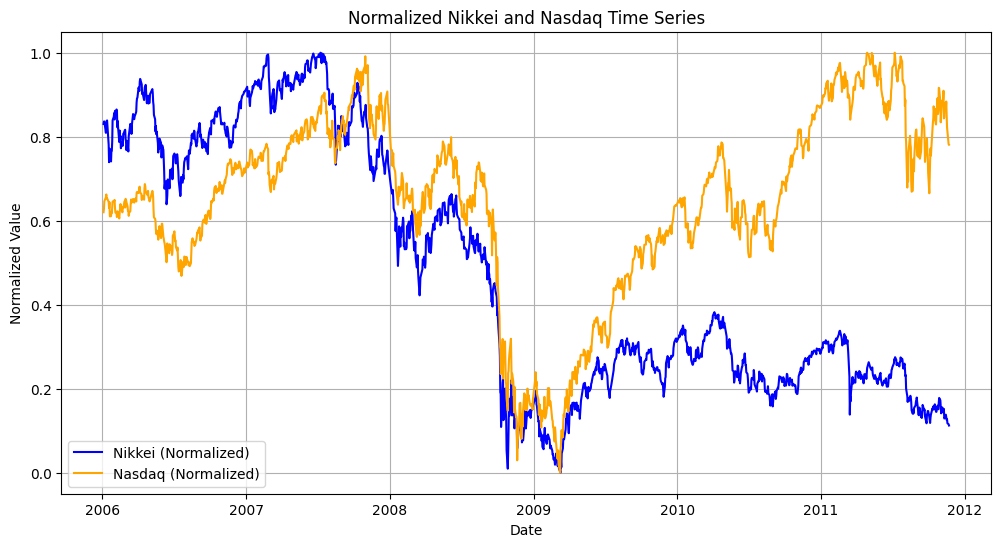

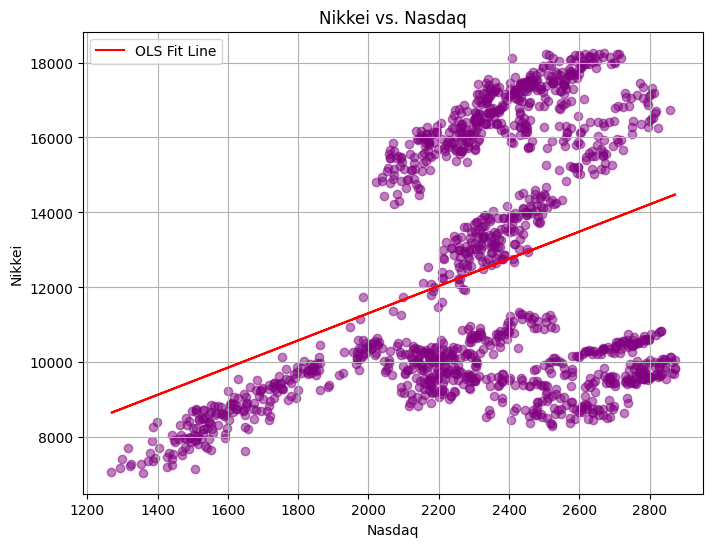

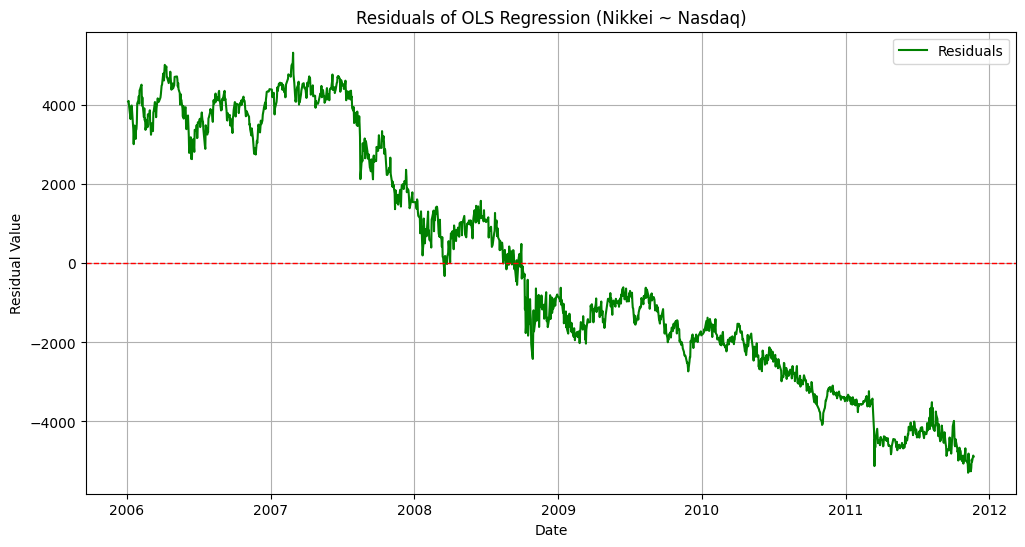

<Figure size 1000x600 with 0 Axes>

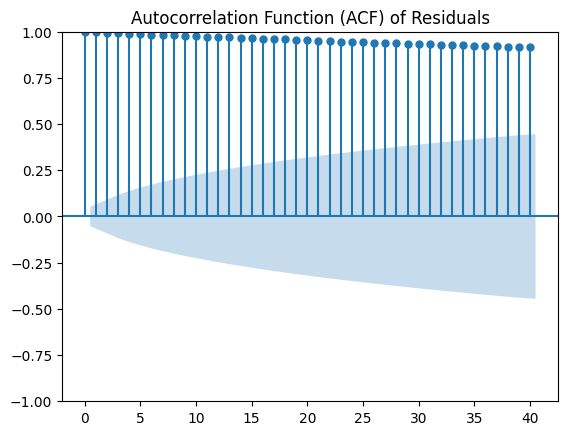

                            OLS Regression Results                            
Dep. Variable:                  ^N225   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     227.5
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           9.64e-48
Time:                        14:30:59   Log-Likelihood:                -13202.
No. Observations:                1397   AIC:                         2.641e+04
Df Residuals:                    1395   BIC:                         2.642e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4053.0387    561.143      7.223      0.0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf

# Step 1: Load Nikkei and Nasdaq data starting in 2006
start_date = '2006-01-01'
end_date = '2011-11-25'

# Fetch data using yfinance
nikkei = yf.download('^N225', start=start_date, end=end_date)
nasdaq = yf.download('^IXIC', start=start_date, end=end_date)

# Align the two time series using 'inner' join to ensure only common dates are included
# Reset index to use dates as a regular column for merging
data = pd.merge(nikkei[['Close']].rename(columns={'Close': 'Nikkei'}),
                nasdaq[['Close']].rename(columns={'Close': 'Nasdaq'}),
                left_index=True, right_index=True, how='inner')

# Normalize the time series for comparison (Min-Max Scaling)
data['Nikkei_normalized'] = (data['Nikkei'] - data['Nikkei'].min()) / (data['Nikkei'].max() - data['Nikkei'].min())
data['Nasdaq_normalized'] = (data['Nasdaq'] - data['Nasdaq'].min()) / (data['Nasdaq'].max() - data['Nasdaq'].min())

# Step 2: Perform OLS regression (Nasdaq as predictor, Nikkei as response)
X = sm.add_constant(data['Nasdaq'])  # Add constant for intercept
y = data['Nikkei']
model = sm.OLS(y, X).fit()
residuals = model.resid

# Step 3: Plot normalized time series for Nikkei and Nasdaq
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Nikkei_normalized'], label='Nikkei (Normalized)', color='blue')
plt.plot(data.index, data['Nasdaq_normalized'], label='Nasdaq (Normalized)', color='orange')
plt.title('Normalized Nikkei and Nasdaq Time Series')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid()
plt.show()

# Step 4: Plot Nikkei against Nasdaq
plt.figure(figsize=(8, 6))
plt.scatter(data['Nasdaq'], data['Nikkei'], alpha=0.5, color='purple')
plt.plot(data['Nasdaq'], model.predict(X), color='red', label='OLS Fit Line')
plt.title('Nikkei vs. Nasdaq')
plt.xlabel('Nasdaq')
plt.ylabel('Nikkei')
plt.legend()
plt.grid()
plt.show()

# Step 5: Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(data.index, residuals, label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='red', linewidth=1)
plt.title('Residuals of OLS Regression (Nikkei ~ Nasdaq)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid()
plt.show()

# Step 6: Plot ACF of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

# Display regression summary
print(model.summary())


#Phillips Ouliaris Test

In [4]:
from statsmodels.tsa.stattools import coint

In [5]:
# Step 3: Perform Phillips-Ouliaris Cointegration Test
# Null hypothesis: No cointegration
coint_t_stat, p_value, crit_values = coint(data['Nikkei'], data['Nasdaq'])
print("\nPhillips-Ouliaris Cointegration Test:")
print(f"Test Statistic: {coint_t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Critical Values: {crit_values}")


Phillips-Ouliaris Cointegration Test:
Test Statistic: -0.4682
P-value: 0.9665
Critical Values: [-3.9043024  -3.34051036 -3.0474895 ]


#Granger Test

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, coint
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

def earle_granger_test(data, maxlag=4):
    """
    Earle Granger-style causality testing between two time series.
    Args:
        data (pd.DataFrame): A DataFrame with two columns, e.g., ['Nasdaq', 'Nikkei'].
        maxlag (int): Maximum number of lags for Granger causality testing.
    Returns:
        dict: Results for stationarity, cointegration, and Granger causality tests.
    """
    results = {}

    # Step 1: Stationarity (ADF Test)
    adf_nasdaq = adfuller(data['Nasdaq'])
    adf_nikkei = adfuller(data['Nikkei'])
    results['stationarity'] = {
        'Nasdaq': {'ADF Statistic': adf_nasdaq[0], 'p-value': adf_nasdaq[1]},
        'Nikkei': {'ADF Statistic': adf_nikkei[0], 'p-value': adf_nikkei[1]},
    }
    print("\nStationarity Results (ADF Test):")
    print(f"Nasdaq: ADF Statistic = {adf_nasdaq[0]}, p-value = {adf_nasdaq[1]}")
    print(f"Nikkei: ADF Statistic = {adf_nikkei[0]}, p-value = {adf_nikkei[1]}")

    # Step 2: Cointegration (Phillips-Ouliaris Test)
    coint_t_stat, p_value, crit_values = coint(data['Nasdaq'], data['Nikkei'])
    results['cointegration'] = {
        't-statistic': coint_t_stat,
        'p-value': p_value,
        'critical values': crit_values,
    }
    print("\nCointegration Results:")
    print(f"T-Statistic = {coint_t_stat}, p-value = {p_value}")
    print(f"Critical Values = {crit_values}")

    # Step 3: Granger Causality Test
    print("\nGranger Causality Results:")
    granger_results = grangercausalitytests(data[['Nasdaq', 'Nikkei']], maxlag=maxlag, verbose=True)
    results['granger_causality'] = {
        lag: granger_results[lag][0] for lag in range(1, maxlag + 1)
    }

    return results

# Example usage
# Replace this random data with actual Nikkei and Nasdaq data
np.random.seed(42)
data = pd.DataFrame({
    'Nasdaq': np.random.randn(100).cumsum(),
    'Nikkei': np.random.randn(100).cumsum(),
})

# Perform the Earle Granger test
results = earle_granger_test(data, maxlag=3)



Stationarity Results (ADF Test):
Nasdaq: ADF Statistic = -1.3583317659818992, p-value = 0.6020814791099098
Nikkei: ADF Statistic = -1.8975904890519297, p-value = 0.33319546838684744

Cointegration Results:
T-Statistic = -1.2577813673543186, p-value = 0.8421141555093162
Critical Values = [-4.01048603 -3.39854434 -3.08756793]

Granger Causality Results:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0919  , p=0.7624  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0919  , p=0.7624  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9449  , p=0.3924  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=1.9913  , p=0.3695  , df=2
likelihood ratio test: chi2=1.9714  , p=0.3732  , df=2
parameter F test:         F=0.9449  , p=0.3924  , df_denom=93, df_num=2

Granger Causality
number of lags (no zero) 3